In [3]:
# 필요 라이브러리 import

import cv2
import numpy as np
from matplotlib import pyplot as plt

# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리

from pixellib.semantic import semantic_segmentation

Matplotlib is building the font cache; this may take a moment.


In [4]:
# PixelLib으로 사용할 세그멘테이션 모델을 생성

model = semantic_segmentation()
model.load_pascalvoc_model('./data/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

In [5]:
# PASCAL VOC 데이터의 라벨
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [6]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [7]:
def make_blur(img_path, label,bg_img=None):
    
    label_id = None
    
    #이미지 읽어서 img 변수에 저장하기
    img = cv2.imread(img_path)
    
    
    # model 을 통해 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(img_path)
      
    # 세그멘테이션 결과 여러가지 클래스가 나올 수 있으므로, 파라메타로 받은 대상의 id 값만 label_id 변수에 저장
    for class_id in segvalues['class_ids']:
        if LABEL_NAMES[class_id] == label:
            label_id = int(class_id)
            
    if label_id == None :
        return print('입력하신 label 값을 확인해 주세요')

    # 우리가 관심 있는 대상의 컬러맵 값을 추출
    seg_color = np.flip(colormap[label_id])
    
    # np.all(조건) - 배열의 모든 데이터가 조건과 맞으면 True 하나라도 다르면 False
    seg_map = np.all(output==seg_color, axis=-1)

    # 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
    img_show = img.copy()
    
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255
    
    
    # 255와 0을 적당한 색상으로 바꿔봅니다
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    
    # 원본 이미지와 마스트를 적당히 합쳐봅니다
    # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
    
    plt.figure(figsize=(10,15))
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # (50,50)은 blurring kernel size를 뜻합니다
    img_orig_blur = cv2.blur(img, (50,50))
    
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 찾고자 하는 대상은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)    

    
    # np.where(조건, 참일때, 거짓일때)
    # 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
    # 아닌 영역은 블러된 이미지 값을 사용합니다.
    img_concat = np.where(img_mask_color==255, img, img_bg_blur)
    
    
    # plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
    # cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
    # cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
    # 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
    plt.figure(figsize=(10,15))
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 만약 배경 이미지가 파라미터 값으로 넘어 올 경우
    if bg_img :
        # 배경이미지를 읽고
        # 원본이미지의 크기와 같도록 resize
        bg_img = cv2.imread(bg_img)
        bg_img = cv2.resize(bg_img, (img.shape[1], img.shape[0]))
        # 배경이미지와 마스크 이미지를 and연산하여 배경부분에서 물체가 있는 부분 지우기.
        bg_img = cv2.bitwise_and(bg_img, img_bg_mask) 
        # 세그멘테이션 이미지의 255인 부분의 값만가져오고 아닌 영역은 배경화면 이미지를 가져오기
        img_t = np.where(img_mask_color==255, img, bg_img)
        plt.figure(figsize=(10,15))
        plt.imshow(cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB))
        plt.show()

    

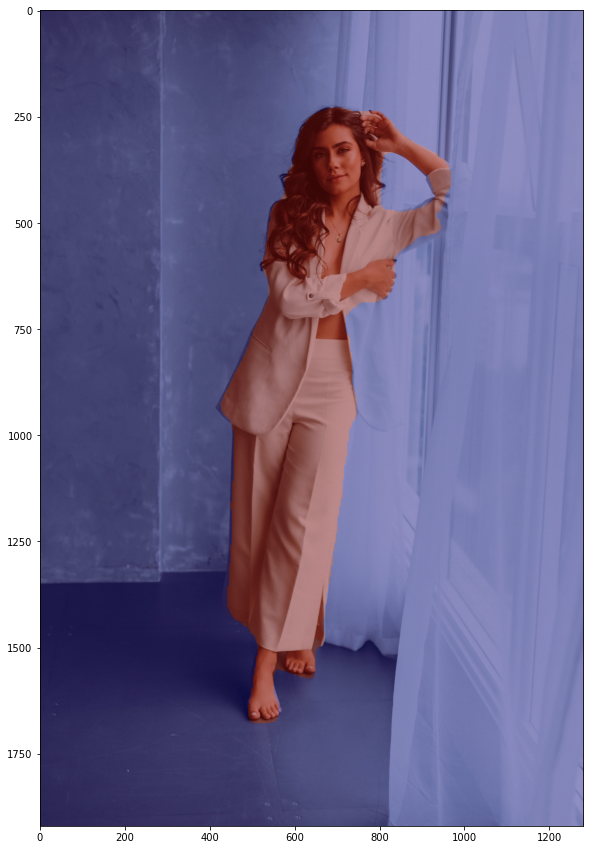

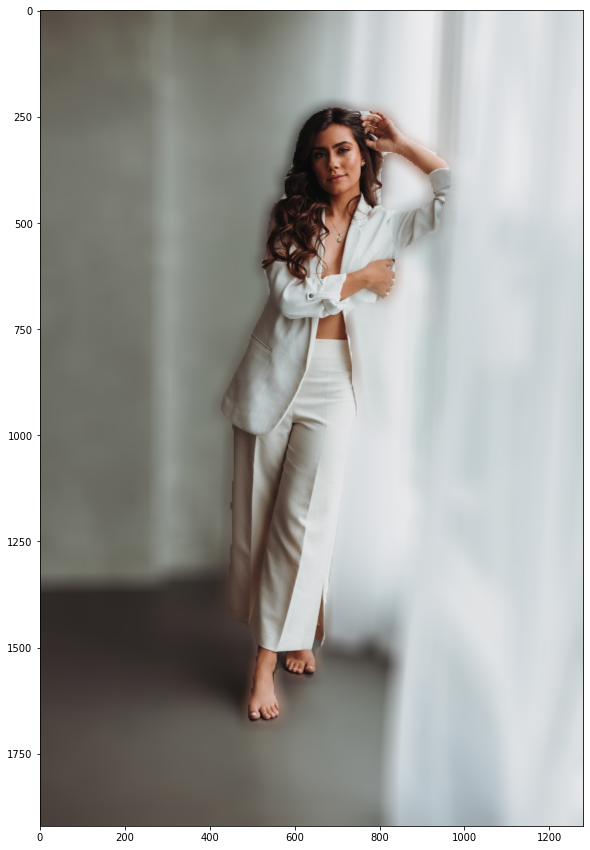

In [8]:
make_blur('./data/img1.jpg', 'person')

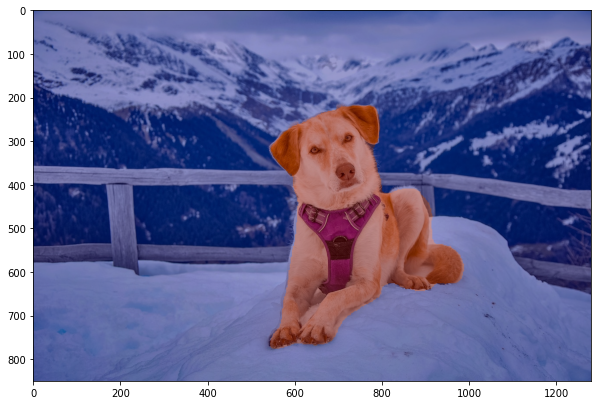

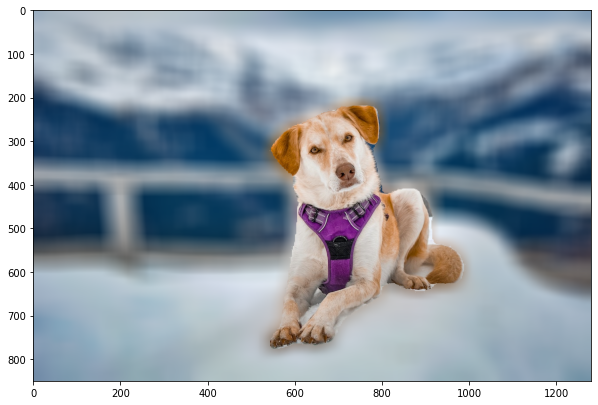

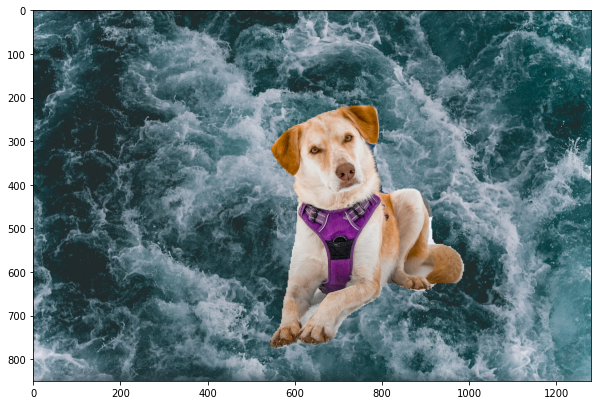

In [9]:
make_blur('./data/img2.jpg', 'dog','./data/back_ground.jpg')

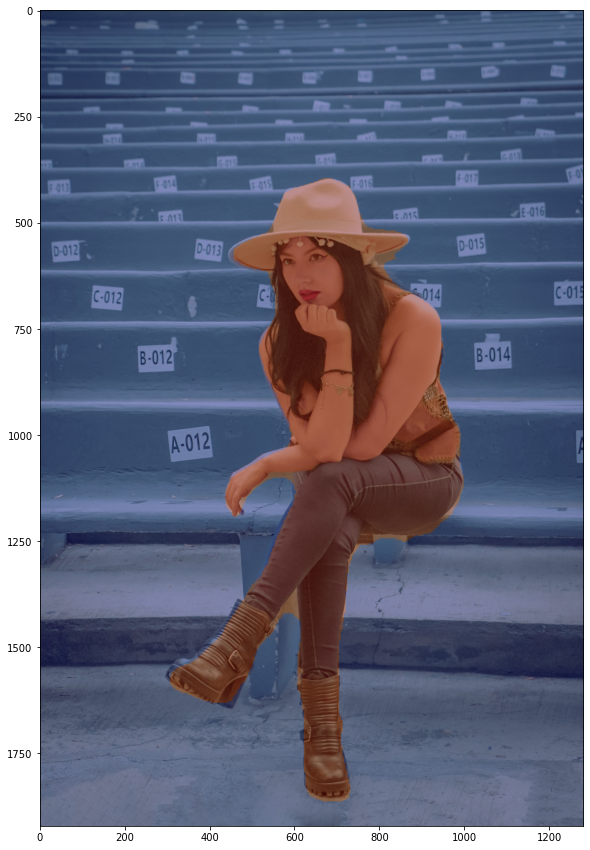

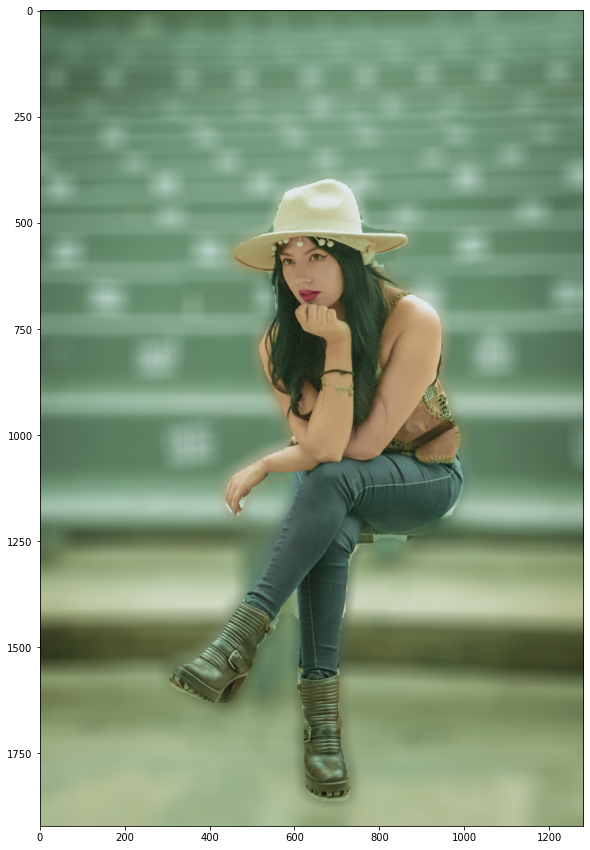

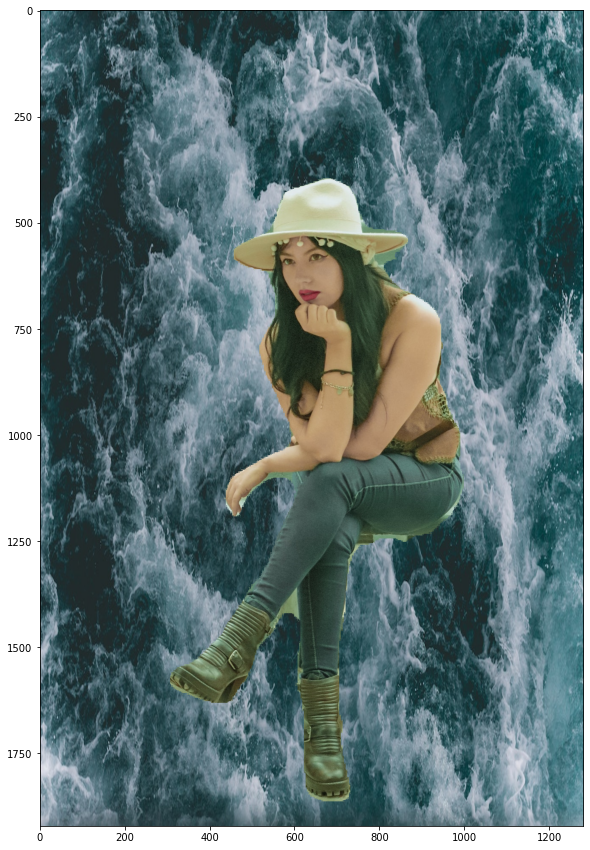

In [10]:
make_blur('./data/img3.jpg', 'person','./data/back_ground.jpg')

### 문제점 찾기

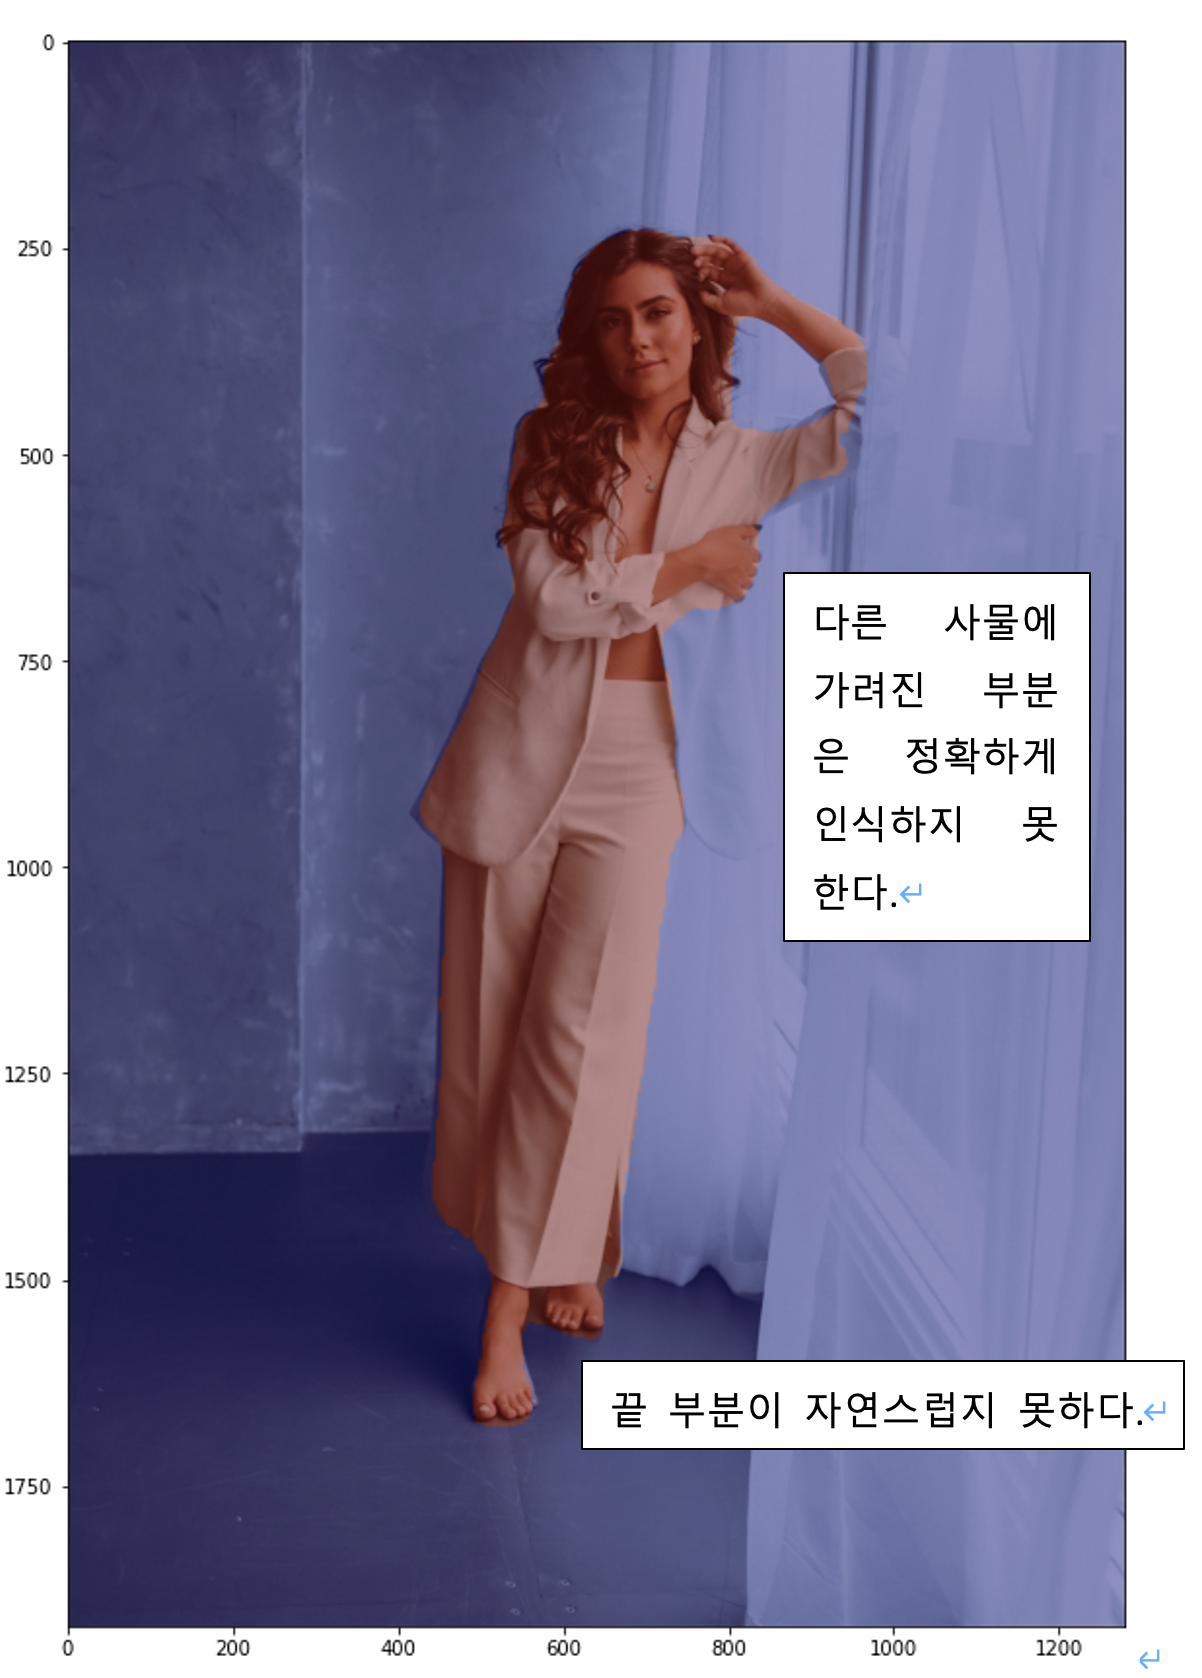

#### 인물모드 사진의 문제점을 개선할 수 있는 솔루션

* 전처리를 통해 인물과 배경의 차이가 명확히 구분이 될 수 있도록 한다.
* 2D카메라의 한계를 극복하기 위해 3D depth 카메라를 활용한다.
(https://m.blog.naver.com/su-zzung/222210294764)
* 다른 모델들과 성능 비교후 적절한 모델을 사용한다 (https://wooono.tistory.com/267)

#### 수정 계획

* 결과 이미지를 저장할 수 있는 기능을 만들면 좋을 것 같음
* 사진에 여러가지 객체가 있을경우 객체들만 남기고 아웃포커싱 기능이 구현 되도록 하기